## Задание Pro



1. Выберите 10 самых красивых по вашем мнению пятерок в тренировочной выборке mnist.
2. Создайте датасет, где объекты – это все пятерки из тренировочной части mnist, а метки – это случайные пятерки из "красивого" набора.
3. Создайте автокодировщик и проверьте, совпадают ли у него размеры выхода и входа.
4. Обучите автокодировщик.
5. Добейтесь ошибки MSE на тренировочной выборке **<0.05**.
6. Посмотрите, как выглядят пятерки из тестовой выборки после обученного автокодировщика.

## Импорт библиотек

In [1]:
# Для операций с тензорами
import numpy as np

# Для отрисвоки
import matplotlib.pyplot as plt

# Для создания модели
from tensorflow.keras.models import Model

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D, Dropout

# Слои для латентного пространства модели
from tensorflow.keras.layers import Flatten, Reshape, Dense

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Для загрузки базы
from tensorflow.keras.datasets import mnist

from tensorflow.keras.regularizers import l2

## Загрузка данных

In [ ]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Нормализация данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [ ]:
# Приведение формы к удобной для Keras
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [ ]:
# Отбор пятерок
mask = y_train == 5
X_train = X_train[mask]
y_train = y_train[mask]

In [ ]:
# Аналогично для тестирования
mask = y_test == 5
X_test = X_test[mask]
y_test = y_test[mask]

## Отбор красивых пятерок

In [ ]:
# Выбираем конкретные пятерки по указанным индексам
selected_indices = [2, 3, 8, 9, 10, 15, 16, 19, 22, 25, 30]
beautiful_fives = X_test[selected_indices]

In [ ]:
# Создание меток - случайные "красивые" пятерки
np.random.seed(42)
labels = beautiful_fives[np.random.randint(0, len(selected_indices), size=len(X_train))]

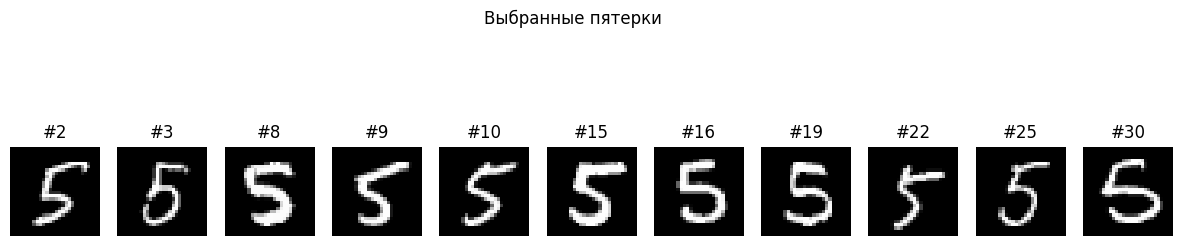

In [ ]:
# Визуализация отобранных пятерок
plt.figure(figsize=(15, 3))
for i, idx in enumerate(selected_indices):
    plt.subplot(1, len(selected_indices), i+1)
    plt.imshow(beautiful_fives[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"#{idx}")
plt.suptitle('Выбранные пятерки', y=1.1)
plt.show()

#Создание модели

In [ ]:
# Входной слой
input_img = Input(shape=(28, 28, 1))

In [ ]:
# Энкодер
x = Conv2D(32, (3, 3), strides=2, padding='same', activation='relu', kernel_regularizer=l2(0.0001))(input_img)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
encoded = BatchNormalization()(x)

# Декодер
x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(encoded)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

# Модель
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Проверка размеров
print("Размер входа:", autoencoder.input_shape)
print("Размер выхода:", autoencoder.output_shape)

Размер входа: (None, 28, 28, 1)
Размер выхода: (None, 28, 28, 1)


# Обучение

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = autoencoder.fit(
    X_train, labels,
    epochs=15,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ],
    verbose=1
)

# Результаты
train_mse = history.history['loss'][-1]
val_mse = history.history['val_loss'][-1]
print(f"Final Train MSE: {train_mse:.5f}")  # Должно быть < 0.05

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0461 - val_loss: 0.0671 - learning_rate: 2.5000e-04
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0442 - val_loss: 0.0693 - learning_rate: 2.5000e-04
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0423 - val_loss: 0.0682 - learning_rate: 2.5000e-04
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0404 - val_loss: 0.0702 - learning_rate: 2.5000e-04
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0386 - val_loss: 0.0727 - learning_rate: 2.5000e-04
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0358 - val_loss: 0.0771 - learning_rate: 2.5000e-04
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0322 - val_loss: 0.0787 - learning_rate: 1.2500e-04
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0282 - val_loss: 0.0814 - learning_rate: 1.2500e-04
Epoch 9/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0262 - val_loss: 0.0845 - learning_rate: 1.2

# Визуализация результатов

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


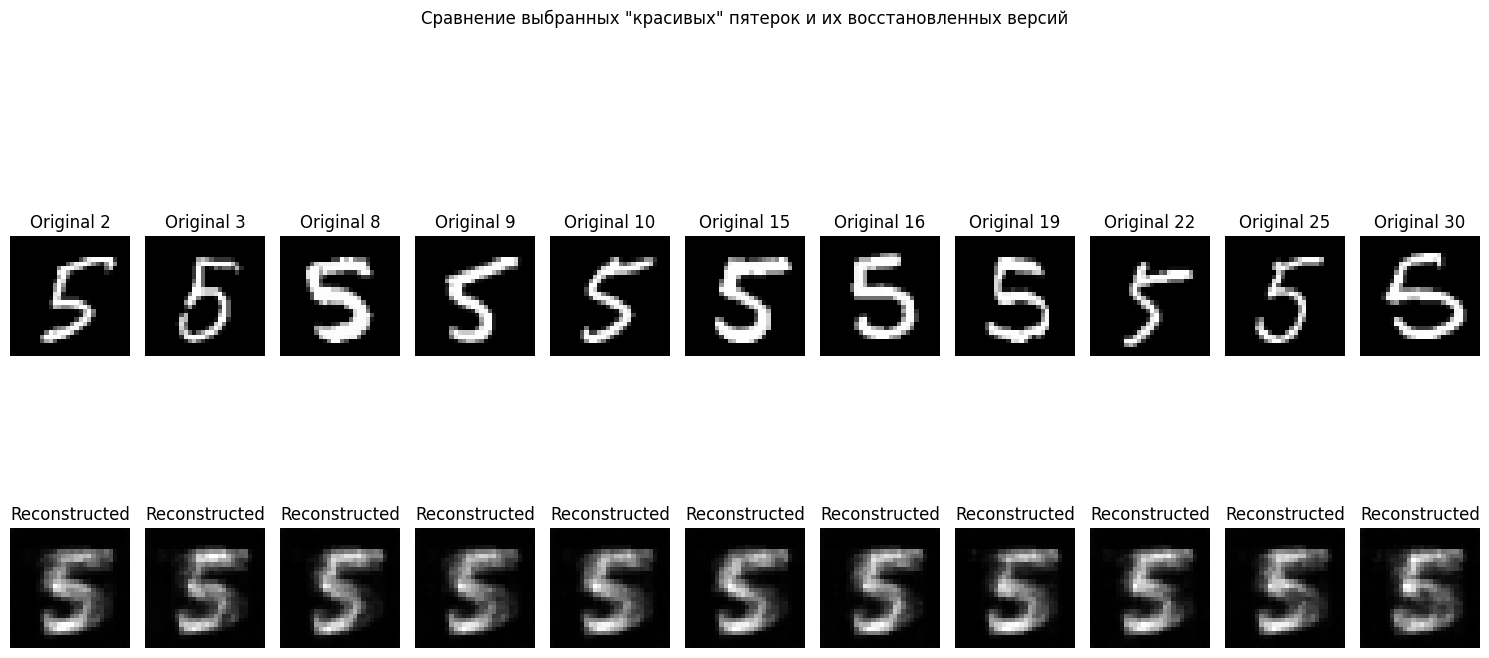

In [ ]:
# Получаем восстановленные версии
reconstructed_beautiful = autoencoder.predict(beautiful_fives)

# Отрисовка сравнения
plt.figure(figsize=(15, 8))
for i in range(len(selected_indices)):
    # Оригинал
    plt.subplot(2, len(selected_indices), i+1)
    plt.imshow(beautiful_fives[i].reshape(28, 28), cmap='gray')
    plt.title(f"Original {selected_indices[i]}")
    plt.axis('off')

    # Восстановленный
    plt.subplot(2, len(selected_indices), i+1+len(selected_indices))
    plt.imshow(reconstructed_beautiful[i].reshape(28, 28), cmap='gray')
    plt.title(f"Reconstructed")
    plt.axis('off')
plt.suptitle('Сравнение выбранных "красивых" пятерок и их восстановленных версий', y=1.02)
plt.tight_layout()
plt.show()